In [10]:
import torch
import numpy as np 
import torch.nn as nn 
import matplotlib.pyplot as plt
# import murenn
import pywt
import scipy

A time-frequency dictionary: $D=\{\phi_\gamma\}$, s.t. $\lVert \phi_\gamma \rVert = 1$  
The time localization $u$ and its spread around $u$ of $\phi_\gamma$ are defined by:
$$
u = \int t \lvert \phi_\gamma(t)^2 \rvert dt \\
\sigma^2 = \int \lvert t-u \rvert ^2 \lvert \phi_\gamma(t)^2 \rvert dt
$$

In [11]:
def get_time_localisation(x):
    '''
    Calculate the time spread of x
    '''
    # x : np.array(N)
    mean,var = 0, 0
    for n in range(len(x)):
        mean += n*x[n]**2
    for n in range(len(x)):
        var += (n-mean)**2 * x[n]**2
    return var

In [12]:
class AP_MuReNN(nn.Module):
    def __init__(self, kernel_size, alpha=0, wavelet='db5', level=3, std=1.0):
        '''
        A reridual murenn network
        ----
        Args: 
        alpha: weight for residual block
        level: wavelet decomposition level
        std: standard deviation of conv1d's normal distribution
        '''
        super().__init__()
        self.kernel_size = kernel_size
        self.alpha = alpha
        self.wavelet = pywt.Wavelet(wavelet)
        self.J = level
        self.conv1d = []
        for j in range(level+1):
            conv1d = nn.Conv1d(1, 1, self.kernel_size, padding = 'same', bias = False)
            nn.init.normal_(conv1d.weight, std = std)
            self.conv1d.append(conv1d)

    def forward(self, x):
        # x : B*C*L tensor
        x_js = pywt.wavedec(x[0,0,:].numpy(), self.wavelet, level=self.J)
        x_js = [torch.from_numpy(x_js[j]).reshape(1,1,-1) for j in range(self.J+1)]
        Ux = []
        for j in range(self.J+1):
            # /(self.J*self.kernel_size)**0.5 : to preserve energy
            Ux_j = (1 - self.alpha) * self.conv1d[j](x_js[j])/(self.J*self.kernel_size)**0.5 + self.alpha * x_js[j]
            Ux.append(Ux_j[0,0,:].numpy())
        y = pywt.waverec(Ux, self.wavelet)
        return y

class Res_Conv1d(nn.Module):
    def __init__(self, kernel_size, alpha=0):
        '''
        A reridual convnet
        ----
        '''
        super().__init__()
        self.kernel_size = kernel_size
        self.alpha = alpha
        self.conv1d = nn.Conv1d(1, 1, self.kernel_size, padding = 'same', bias = False)
        nn.init.normal_(self.conv1d.weight)
    def forward(self, x):
        y = self.conv1d(x)/self.kernel_size**0.5
        return (1-self.alpha)*y+self.alpha*x

In [13]:
class AP_Conv1d(nn.Module):
    def __init__(self, kernel_size, level = 1):
        super().__init__()
        '''
        A dilated convnet
        ----
        '''
        self.kernel_size = kernel_size
        self.J = level
        self.conv1d = [nn.Conv1d(1, 1,
                                 self.kernel_size, 
                                 padding = 'same',
                                 dilation= 2**j,
                                 bias = False) for j in range(level)] 
        for j, conv1d in enumerate(self.conv1d):
            nn.init.normal_(conv1d.weight)

    def forward(self, x):
        y = torch.zeros(x.shape)
        for j in range(self.J):
            xj = self.conv1d[j](x)/(self.J*self.kernel_size)**0.5
            y += xj
        return y

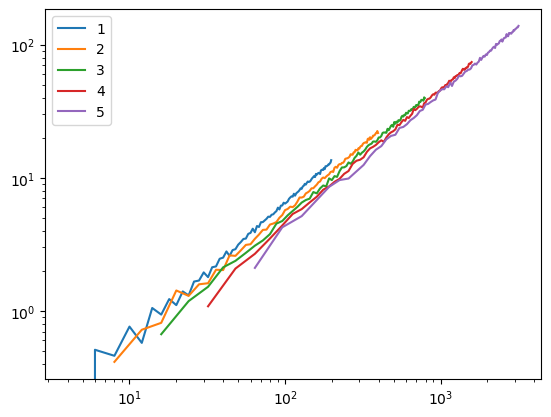

In [14]:
L = 2**10
x = torch.zeros(1,1,L,requires_grad=False)
x[0,0,0] = 1
iteration = 50
js = range(1, 6)

with torch.no_grad():
    N_list = range(2,100)
    ap_tl_j = []
    ap_rf_j = []
    for j in js:
        ap_tl = []
        ap_rf = []
        for N in N_list:
            tls = np.zeros(iteration)
            for i in range(iteration):
                ap_conv1d = AP_Conv1d(kernel_size=N, level=j)
                y = ap_conv1d(x)[0,0,:].numpy()
                tls[i] = get_time_localisation(y)
            ap_tl.append(np.mean(tls))
            ap_rf.append(2**j * N)
        ap_tl_j.append(np.sqrt(np.array(ap_tl)))
        ap_rf_j.append(np.array(ap_rf))
    # time localisation with kernel size

 

In [15]:
L = 2**12
x = torch.zeros(1,1,L,requires_grad=False)
x[0,0,0] = 1
iteration = 50
js = range(1, 6)

with torch.no_grad():
    N_list = range(2,100)
    ap_tl_j = []
    ap_rf_j = []
    for j in js:
        ap_tl = []
        ap_rf = []
        for N in N_list:
            tls = np.zeros(iteration)
            for i in range(iteration):
                ap_murenn = AP_MuReNN(kernel_size=N, level=j)
                y = ap_murenn(x)
                tls[i] = get_time_localisation(y)
            ap_tl.append(np.mean(tls))
            ap_rf.append(2**j * N)
        ap_tl_j.append(np.sqrt(np.array(ap_tl)))
        ap_rf_j.append(np.array(ap_rf))
    # time localisation with kernel size


Text(0.5, 1.0, 'All Pass MuReNN')

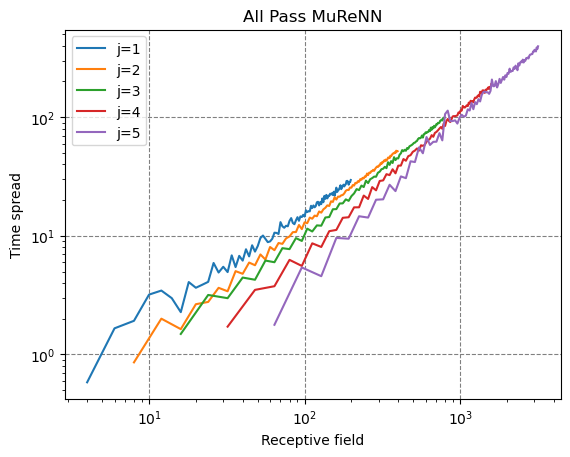

In [16]:
for rf, tl, j in zip(ap_rf_j, ap_tl_j, js):
    plt.loglog(rf, tl, label=f"j={j}")
plt.legend()
plt.grid(linestyle='--', color='gray')
plt.xlabel("Receptive field")
plt.ylabel("Time spread")
plt.title('All Pass MuReNN')

torch.Size([1, 1, 23])
torch.Size([1, 1, 23])
torch.Size([1, 1, 38])
torch.Size([1, 1, 68])


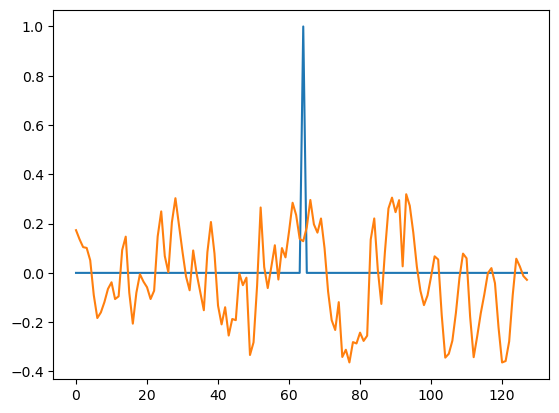

In [22]:
L = 32 #kernel size
N = 2**7 #signal length
wavelet = pywt.Wavelet('db5')
# input
x = torch.zeros(1,1,N,requires_grad=False)
nn.init.dirac_(x)
# multilevel decomposition using pywt
x_js = pywt.wavedec(x[0,0,:].numpy(), wavelet)
Ux = []
conv1d = nn.Conv1d(1, 1, L, padding = 'same',bias = False)
# perform conv1d for each component
with torch.no_grad():
    for j in range(len(x_js)):
        nn.init.normal_(conv1d.weight)
        Ux_j = conv1d(torch.from_numpy(x_js[j]).unsqueeze(0).unsqueeze(0) / (2**j))
        Ux.append(Ux_j[0,0,:].numpy())
# invers transform
y = pywt.waverec(Ux, wavelet)
plt.plot(x[0,0,:])
plt.plot(y)